In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
params = {'xtick.labelsize': 18,
 'ytick.labelsize': 18,
 'axes.titlesize' : 22,
 'axes.labelsize' : 20,
 'legend.fontsize': 18,
 'legend.title_fontsize': 22,
 'figure.titlesize': 24
 }
pylab.rcParams.update(params)

In [2]:
dataset = pd.read_csv("HW3_data.csv")
pd.set_option('display.max_columns', None)

In [3]:
dataset.head()

,patient_id,age,sex,weight,blood_type,current_location,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,sport_activity,symptoms,pcr_date,PCR_01,PCR_02,PCR_03,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10,contamination_level
0,263,16,F,64.1,A+,"('24.41288', '76.56719')",1,6,2,11,108,1,NaN,05-07-20,-4.598459,-11.204668,8.933243,247.230139,96.959642,11.792748,15.306437,3.929300,-214.682711,-56.344700,10.616771
1,1768,43,M,83.9,O+,"('55.75556', '60.70278')",1,9,6,2,116,0,NaN,12-02-20,2.090646,-11.118427,3.265275,57.421509,80.148318,7.616542,13.694204,5.016285,123.782023,-20.013564,13.940998
2,1374,44,M,101.5,A+,"('-26.93366', '29.24152')",0,8,1,3,112,2,cough;shortness_of_breath,26-07-20,3.742559,4.206684,2.014962,188.574377,229.499560,11.877267,-10.522185,4.745999,-65.856248,-24.400732,28.188468
3,1292,22,M,74.6,O+,"('48.78232', '9.17702')",1,6,3,1,109,0,NaN,07-11-20,-1.418033,-1.529560,7.941965,171.914488,315.920977,23.848574,-15.782997,4.323900,353.633326,-64.236355,22.976276
4,818,10,F,37.9,O+,"('39.78504', '-85.76942')",1,6,1,1,89,2,sore_throat,26-04-21,-3.234428,0.447605,9.567185,76.922690,215.179195,13.824784,-15.339006,11.384751,-41.861680,-62.901711,20.128380


In [4]:
# train-test split
from sklearn.model_selection import train_test_split
seed = 68 + 31 # sum of last two digits of IDs
train_raw, test_raw = train_test_split(dataset, test_size=0.2, random_state=seed)

In [5]:
# data preparation

def prepare_data(training_data, new_data):
    import pandas as pd

    training_data = training_data.copy()
    out_data = new_data.copy()

    # make blood_type into blood_type_A, blood_type_AB, blood_type_O
    prepare_blood_type(training_data)
    prepare_blood_type(out_data)

    # split symptoms into each symptom
    prepare_symptoms(training_data)
    prepare_symptoms(out_data)

    # make sex -> male
    prepare_male(training_data)
    prepare_male(out_data)

    # current_location -> x, y
    prepare_location(training_data)
    prepare_location(out_data)

    # pcr_date -> days since 1/1/2020
    prepare_pcr_date(training_data)
    prepare_pcr_date(out_data)

    to_min_max_scale = ["patient_id",
                        "age",
                        "sport_activity",
                        "pcr_date",
                        "PCR_01",
                        "PCR_02",
                        "PCR_03",
                        "PCR_04",
                        "PCR_05",
                        "PCR_07",
                        "PCR_09",
                        "PCR_10",
                        "x_location",
                        "y_location"]

    to_standard_scale = ["weight",
                        "num_of_siblings",
                        "happiness_score",
                        "household_income",
                        "conversations_per_day",
                        "sugar_levels",
                        "PCR_06",
                        "PCR_08"]
    
    # fit to training_data, transform out_data
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    min_max_scaler = MinMaxScaler((-1, 1))
    min_max_scaler.fit(training_data[to_min_max_scale])
    out_data[to_min_max_scale] = min_max_scaler.transform(out_data[to_min_max_scale])

    standard_scaler = StandardScaler()
    standard_scaler.fit(training_data[to_standard_scale])
    out_data[to_standard_scale] = standard_scaler.transform(out_data[to_standard_scale])

    return out_data

def prepare_blood_type(data):
    data["blood_type_A"] = data["blood_type"].isin(["A+", "A-"]).astype(int)
    data["blood_type_AB"] = data["blood_type"].isin(["AB+", "AB-", "B+", "B-"]).astype(int)
    data["blood_type_O"] = data["blood_type"].isin(["O+", "O-"]).astype(int)
    data.drop("blood_type", axis=1, inplace=True)
    return data

def prepare_symptoms(data):
    data["symptoms"].fillna("", inplace=True)
    allSymptoms = set()
    for symptoms in data["symptoms"].unique():
        allSymptoms.update(symptoms.split(";"))
    allSymptoms.remove("")
    for symptom in allSymptoms:
        data[symptom] = data["symptoms"].str.contains(symptom).map({True: 1, False: 0})
    data.drop("symptoms", axis=1, inplace=True)
    return data

def prepare_male(data):
    data.rename({"sex" : "male"}, axis=1, inplace=True)
    data["male"].replace({"M" : 1, "F" : 0}, inplace=True)
    return data

def prepare_location(data):
    data["x_location"] = data["current_location"].str.split(",").str[0]
    data["y_location"] = data["current_location"].str.split(",").str[1]
    data["x_location"] = data["x_location"].str.replace("(", "").str.replace("'", "").astype(float)
    data["y_location"] = data["y_location"].str.replace(")", "").str.replace("'", "").astype(float)
    data.drop("current_location", axis=1, inplace=True)
    return data

def prepare_pcr_date(data):
    import pandas as pd
    data["pcr_date"] = pd.to_datetime(data["pcr_date"], format="%d-%m-%y")
    data["pcr_date"] = (data["pcr_date"] - pd.to_datetime("2020-01-01")).dt.days
    return data

In [6]:
train = prepare_data(train_raw, train_raw)
test = prepare_data(train_raw, test_raw)

In [7]:
train.head()

,patient_id,age,male,weight,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,sport_activity,pcr_date,PCR_01,PCR_02,PCR_03,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10,contamination_level,blood_type_A,blood_type_AB,blood_type_O,cough,shortness_of_breath,smell_loss,sore_throat,fever,x_location,y_location
207,-0.817635,-0.411765,1,1.576194,0.357705,-0.048767,-0.721053,-0.112704,0.493738,-0.5,0.543956,-0.537456,-0.727302,0.180713,-0.587480,-0.186780,-0.386469,-0.339160,0.881980,-0.920711,0.081999,20.233594,0,1,0,0,0,0,0,0,0.318219,0.380992
883,-0.027054,-0.905882,0,-1.239626,-1.214626,-0.787656,0.006548,-0.112704,-0.361219,-1.0,0.310440,-0.793623,0.497972,0.274420,0.029258,-0.755040,-0.406892,0.757424,0.633222,0.764169,0.038919,43.411584,1,0,0,1,1,1,0,0,0.057434,0.402914
903,-0.893788,-0.223529,1,0.104495,-0.428460,-1.526546,-0.721053,-1.247311,-0.735263,0.0,0.208791,0.654932,-0.944074,0.969501,0.668706,-0.606362,0.014484,0.751155,-0.209762,-0.907421,-0.341352,5.093091,1,0,0,0,0,0,1,0,-0.278124,0.647012
1235,-0.917836,-0.623529,0,0.683151,-0.428460,-1.526546,0.734149,-0.869109,-1.429916,0.5,-0.370879,0.922024,-0.223402,-0.377127,-0.786365,0.105378,0.762726,-0.638544,-0.514880,-0.030923,0.234573,0.912109,0,1,0,0,0,0,0,0,0.579342,-0.799998
1064,0.698397,-0.929412,0,-1.266964,-1.214626,0.690123,0.734149,1.021903,-1.323046,-1.0,0.024725,-0.021935,0.066436,0.081718,-0.373337,-0.069113,-0.749735,-0.482596,1.986516,0.747059,0.097499,16.576480,1,0,0,0,0,0,0,0,0.080550,-0.621134


Section 1

In [8]:
train_subset, val_subset = train_test_split(train, test_size=0.2, random_state=seed)

X_train, y_train = train_subset.drop(columns=["contamination_level"]), train_subset["contamination_level"]
X_val, y_val = val_subset.drop(columns=["contamination_level"]), val_subset["contamination_level"]

In [9]:
from sklearn.base import BaseEstimator, RegressorMixin

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        loss = 1 / (np.shape(X)[0]) * np.linalg.norm(np.dot(X, w) + b - y) ** 2

        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        
        g_w = 2 / (np.shape(X)[0]) * np.dot(X.T, (np.dot(X, w) + b - y))
        g_b = 2 / (np.shape(X)[0]) * np.sum(np.dot(X, w) + b - y)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """
        y_pred = np.dot(X, self.w) + self.b

        return y_pred

In [10]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()

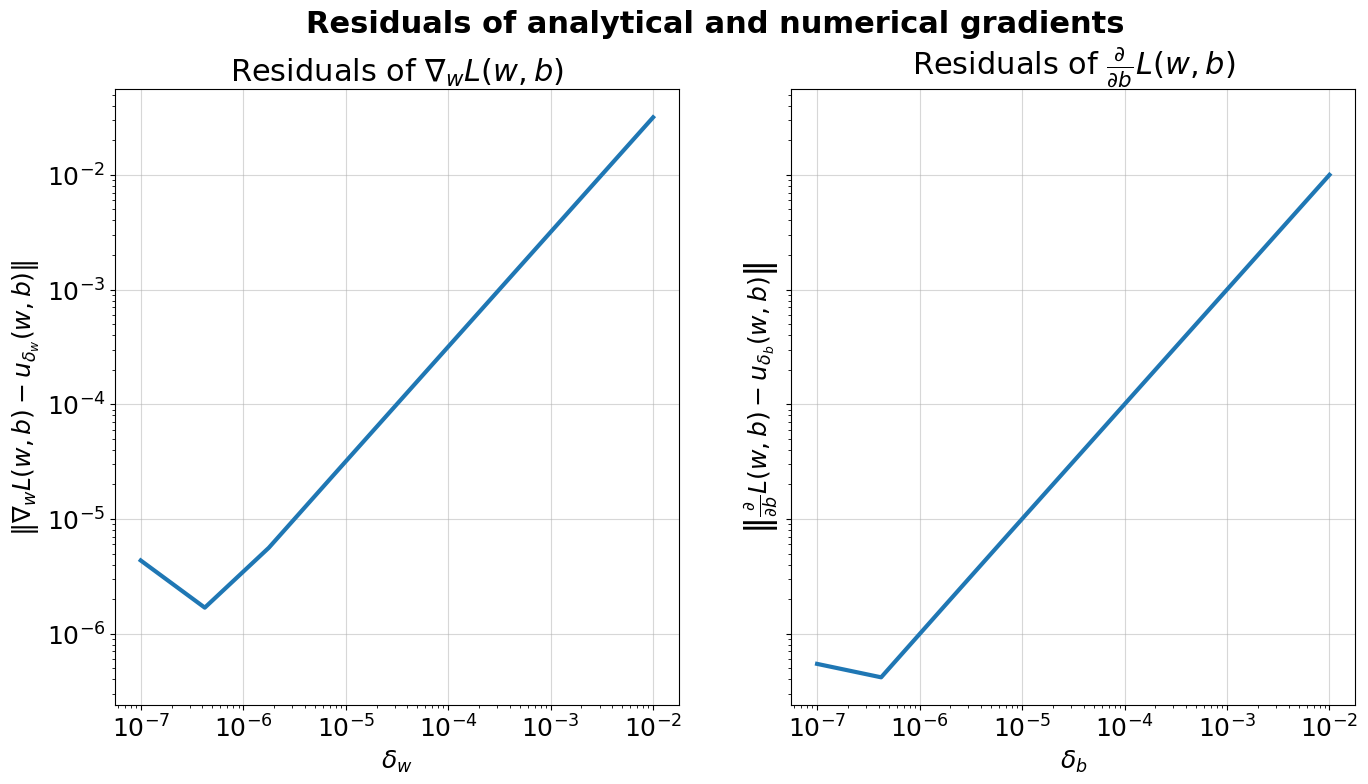

In [11]:
compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 404.0661644531704, Best validation loss = 372.90920525841494
lr size = 1e-08, Best train loss = 404.02708033705267, Best validation loss = 372.87223374507784
lr size = 1e-07, Best train loss = 403.636517484459, Best validation loss = 372.50278339159996
lr size = 1e-06, Best train loss = 399.7585861417598, Best validation loss = 368.8346305330028
lr size = 1e-05, Best train loss = 363.62002304993587, Best validation loss = 334.66533999430345
lr size = 0.0001, Best train loss = 173.44362882682933, Best validation loss = 155.7555181037574
lr size = 0.001, Best train loss = 91.70188099449658, Best validation loss = 86.28425187785642
lr size = 0.01, Best train loss = 85.69524670988417, Best validation loss = 85.67608800312213
lr size = 0.1, Best train loss = 86.71186742549563, Best validation loss = 85.19533473762354


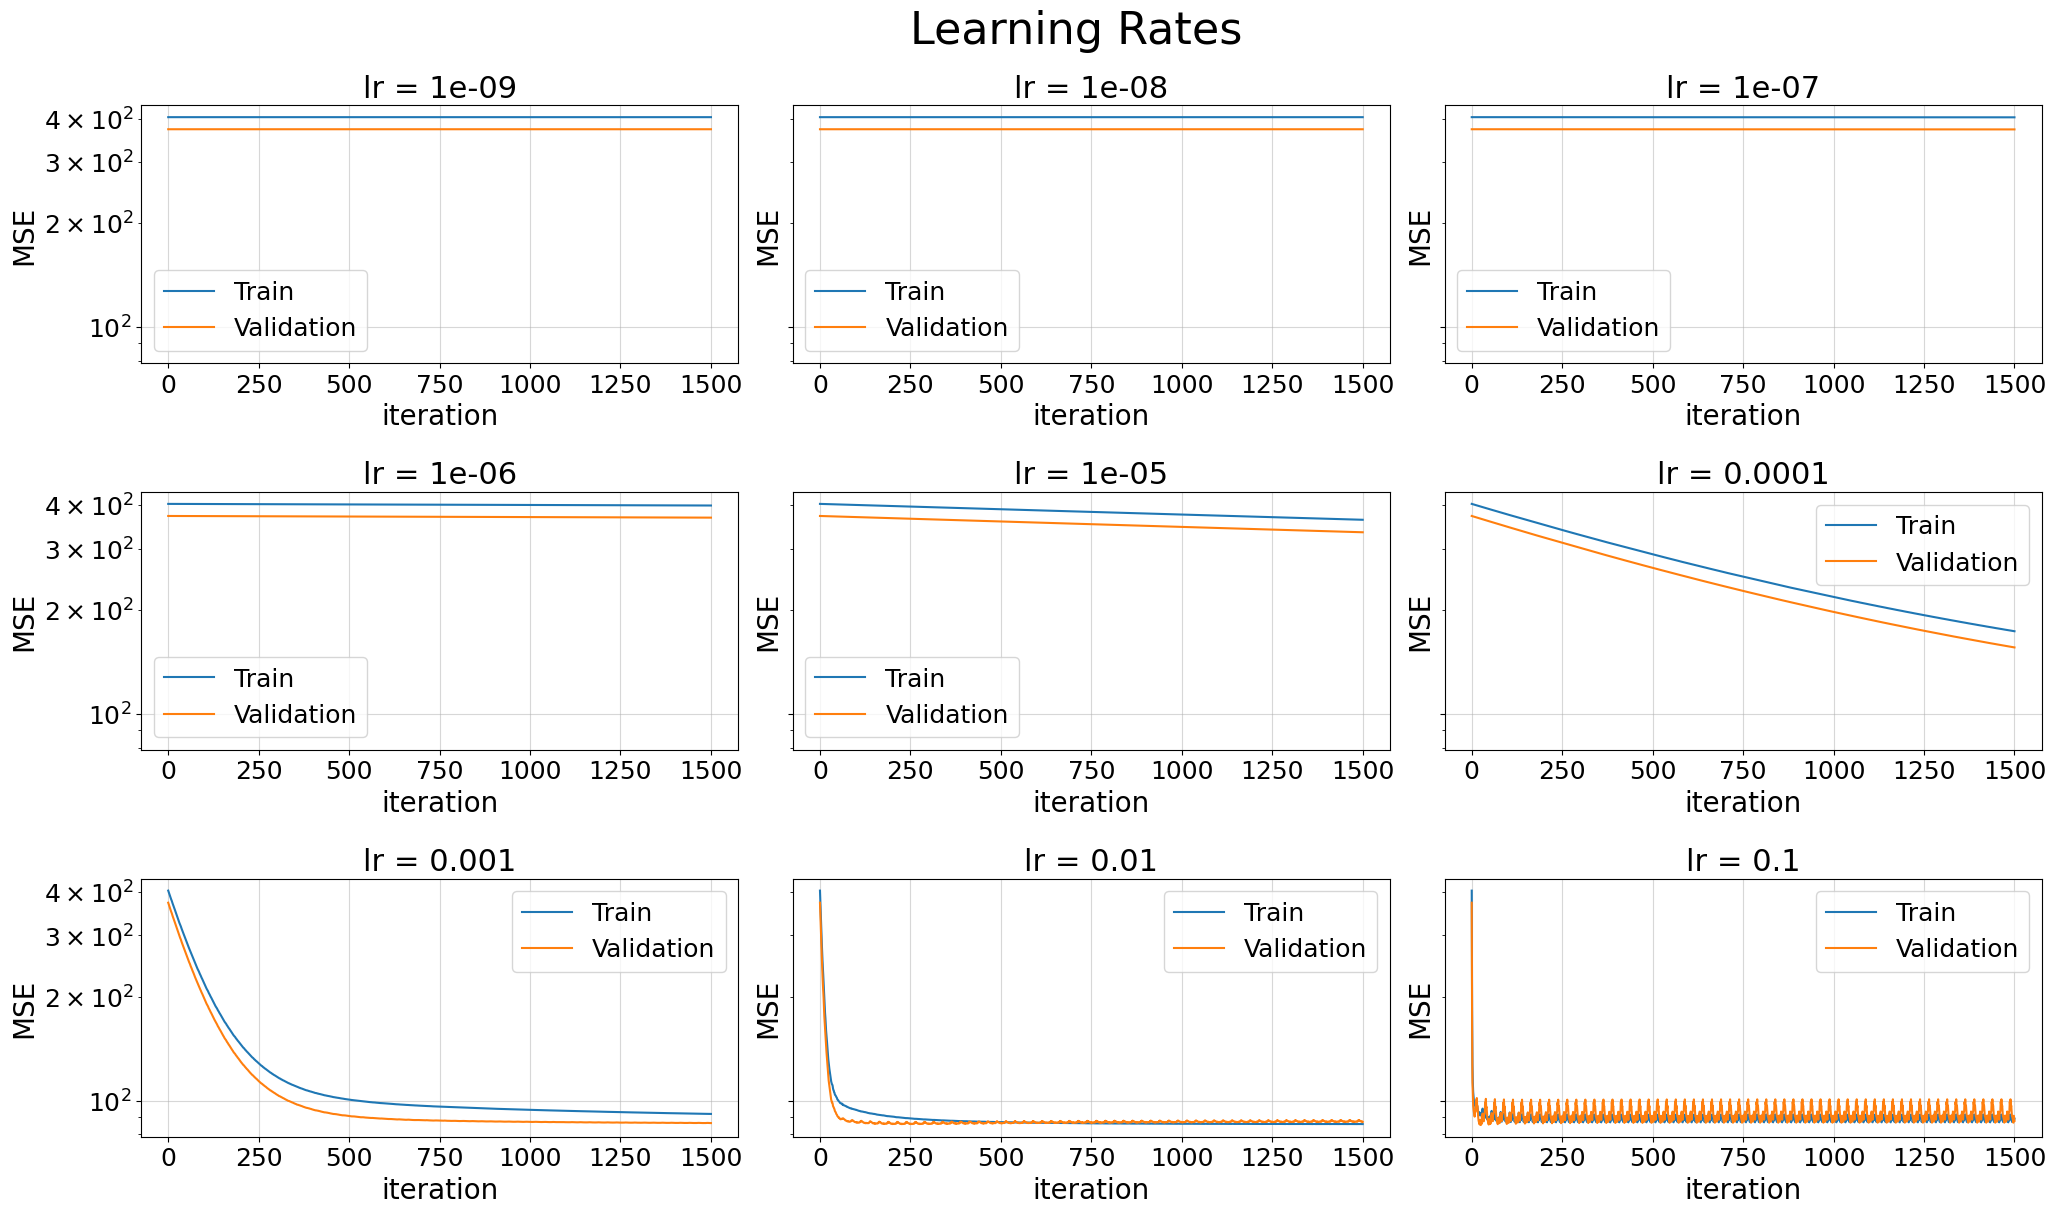

In [13]:
test_lr(X_train, y_train, X_val, y_val, title="Learning Rates")

Section 2

In [14]:
# Q4 - dummy regressor

# we use the entire set now
X_train = train.drop(columns=["contamination_level"])
y_train = train["contamination_level"]

X_test = test.drop(columns=["contamination_level"])
y_test = test["contamination_level"]

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

dummy_model = DummyRegressor(strategy="mean")
dummy_model_mse = cross_validate(dummy_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
dummy_model_train_mse = np.mean(-dummy_model_mse["train_score"])
dummy_model_val_mse = np.mean(-dummy_model_mse["test_score"])
print("Dummy model train MSE: {:.2f}".format(dummy_model_train_mse))
print("Dummy model val MSE: {:.2f}".format(dummy_model_val_mse))

# now we train on entire train set and test on test set
dummy_model.fit(X_train, y_train)
y_predict = dummy_model.predict(X_test)
dummy_model_test_score = mean_squared_error(y_test, y_predict)
print("Dummy model test MSE: {:.2f}".format(dummy_model_test_score))

Dummy model train MSE: 98.79
Dummy model val MSE: 98.94
Dummy model test MSE: 109.55


In [15]:
# Q5 - linear regressor

learning_rates = np.logspace(-9, -1, 9)
cv_test_scores = []
cv_train_scores = []

for lr in learning_rates:
    linear_regressor = LinearRegressor(lr)
    cv_scores = cross_validate(linear_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_jobs=-1)
    cv_train_scores.append(np.mean(-cv_scores["train_score"]))
    cv_test_scores.append(np.mean(-cv_scores["test_score"]))

Best learning rate:  0.01
Train MSE: 84.72
Validation MSE: 92.25


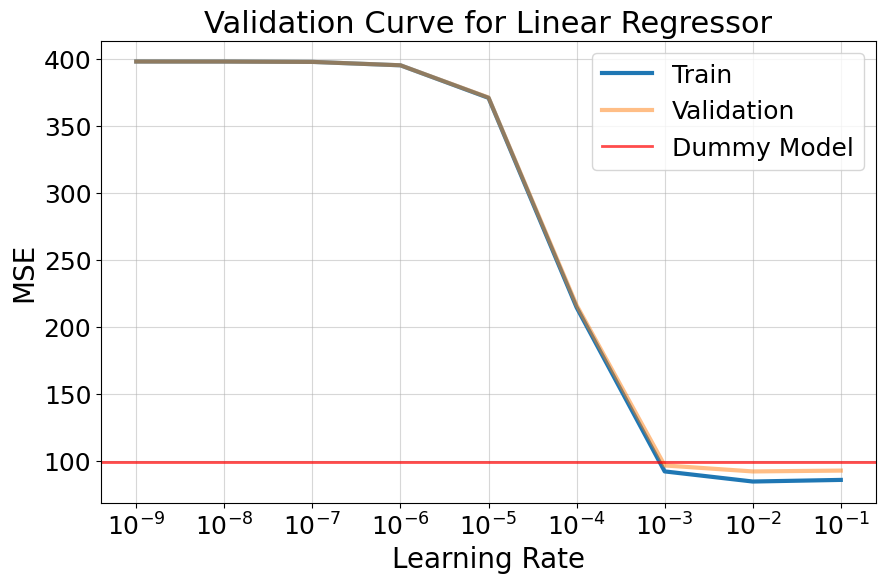

In [16]:
# plotting the results

best_lr = learning_rates[np.argmin(cv_test_scores)]
print("Best learning rate: ", best_lr)
print("Train MSE: {:.2f}".format(cv_train_scores[np.argmin(cv_test_scores)]))
print("Validation MSE: {:.2f}".format(cv_test_scores[np.argmin(cv_test_scores)]))

plt.figure(figsize=(10, 6))
plt.title("Validation Curve for Linear Regressor", fontsize=22)
plt.plot(learning_rates, cv_train_scores, label="Train", linewidth=3)
plt.plot(learning_rates, cv_test_scores, label="Validation", linewidth=3, alpha=0.5)
plt.xlabel("Learning Rate", fontsize=20)
plt.ylabel("MSE", fontsize=20)
plt.grid(alpha=0.5)
plt.semilogx()
plt.xticks(learning_rates)
# plotting the dummy model
plt.axhline(dummy_model_val_mse, color="red", label="Dummy Model", linewidth=2, alpha=0.7)
plt.legend()
plt.show()

In [17]:
# training with the best learning rate

optimal_linear_regressor = LinearRegressor(best_lr)
optimal_linear_regressor.fit(X_train, y_train)
print("Loss on test set: {:.2f}".format(mean_squared_error(y_test, optimal_linear_regressor.predict(X_test))))

Loss on test set: 96.48


Section 3

In [18]:
# Q7 - Ridge Regressor

from sklearn.linear_model import Ridge

alphas = np.logspace(-3, 10, 14, base=4)
cv_test_scores = []
cv_train_scores = []

for alpha in alphas:
    ridge_regressor = Ridge(alpha=alpha, fit_intercept=True)
    cv_scores = cross_validate(ridge_regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_jobs=-1)
    cv_train_scores.append(np.mean(-cv_scores["train_score"]))
    cv_test_scores.append(np.mean(-cv_scores["test_score"]))

Best alpha:  256.0
Train MSE: 86.32
Validation MSE: 90.39


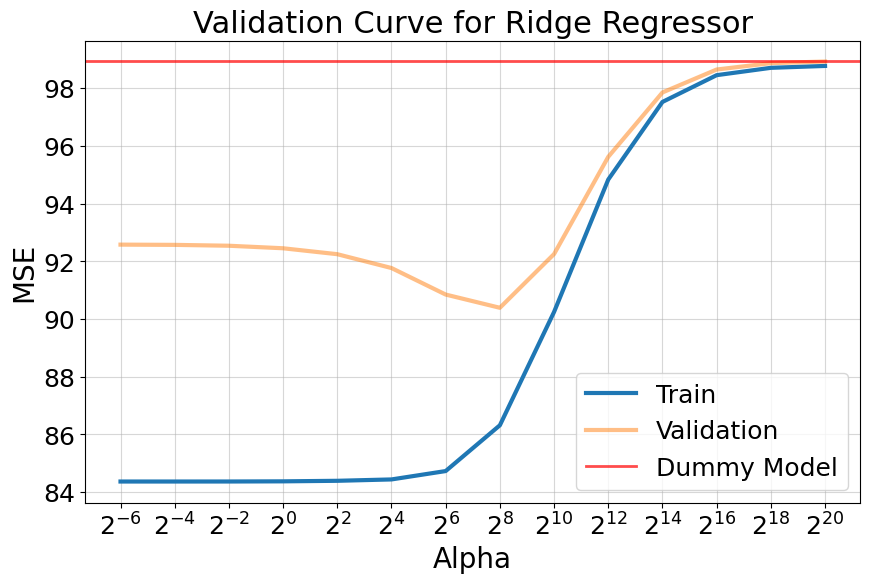

In [19]:
# plotting the results

best_alpha = alphas[np.argmin(cv_test_scores)]
print("Best alpha: ", best_alpha)
print("Train MSE: {:.2f}".format(cv_train_scores[np.argmin(cv_test_scores)]))
print("Validation MSE: {:.2f}".format(cv_test_scores[np.argmin(cv_test_scores)]))

plt.figure(figsize=(10, 6))
plt.title("Validation Curve for Ridge Regressor", fontsize=22)
plt.plot(alphas, cv_train_scores, label="Train", linewidth=3)
plt.plot(alphas, cv_test_scores, label="Validation", linewidth=3, alpha=0.5)
plt.xlabel("Alpha", fontsize=20)
plt.ylabel("MSE", fontsize=20)
plt.grid(alpha=0.5)
plt.semilogx(base=2)
plt.xticks(alphas)
# plotting the dummy model
plt.axhline(dummy_model_val_mse, color="red", label="Dummy Model", linewidth=2, alpha=0.7)
plt.legend()
plt.show()

In [20]:
# training with the best alpha

optimal_ridge_regressor = Ridge(alpha=best_alpha)
optimal_ridge_regressor.fit(X_train, y_train)
print("Loss on test set: {:.2f}".format(mean_squared_error(y_test, optimal_ridge_regressor.predict(X_test))))

Loss on test set: 98.11


In [21]:
# Q9 - largest (in abs) coefficients and their features for ridge regressor

coeffs = np.abs(optimal_ridge_regressor.coef_)
sorted_coeffs = np.sort(coeffs)[::-1] # argsort is from low to high, so we reverse it
sorted_features = optimal_ridge_regressor.feature_names_in_[np.argsort(coeffs)[::-1]]
dict(zip(sorted_features, sorted_coeffs))

{'PCR_01': 2.0123270697757323,
 'sugar_levels': 1.9145923588498126,
 'sport_activity': 0.5166696667403958,
 'PCR_05': 0.4961002900977836,
 'pcr_date': 0.4858243493375069,
 'weight': 0.44126536889347784,
 'blood_type_A': 0.32920279170020417,
 'PCR_03': 0.28139154907038366,
 'shortness_of_breath': 0.274900307089819,
 'cough': 0.23782172383321984,
 'smell_loss': 0.22689882078772827,
 'blood_type_AB': 0.22248783144572742,
 'happiness_score': 0.22029979354607424,
 'PCR_09': 0.2026140888196833,
 'PCR_06': 0.18228184854049082,
 'num_of_siblings': 0.17346233586568252,
 'patient_id': 0.16967274798520923,
 'PCR_07': 0.16346584213415516,
 'PCR_02': 0.15364911960347694,
 'age': 0.11796298197638456,
 'PCR_10': 0.11030525358329275,
 'blood_type_O': 0.10671496025447758,
 'PCR_04': 0.10370201740207792,
 'y_location': 0.09584909778921807,
 'household_income': 0.09262727079701236,
 'male': 0.08900673060700391,
 'PCR_08': 0.05717678067818841,
 'x_location': 0.019658627569054555,
 'fever': 0.0138286219496

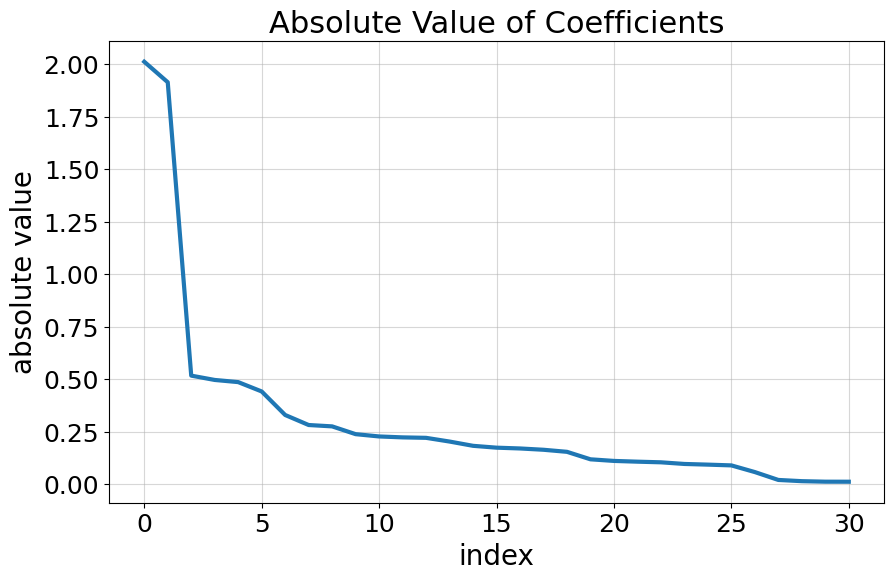

In [22]:
# Q10 - plotting the coefficients

plt.figure(figsize=(10, 6))
plt.title("Absolute Value of Coefficients", fontsize=22)
plt.plot(range(len(coeffs)), sorted_coeffs, linewidth=3)
plt.xlabel("index", fontsize=20)
plt.ylabel("absolute value", fontsize=20)
plt.grid(alpha=0.5)
plt.show()

Section 4

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1, 
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32, y=0.80)
  plt.tight_layout()
  plt.show()

/tmp/ipykernel_6261/1500650511.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


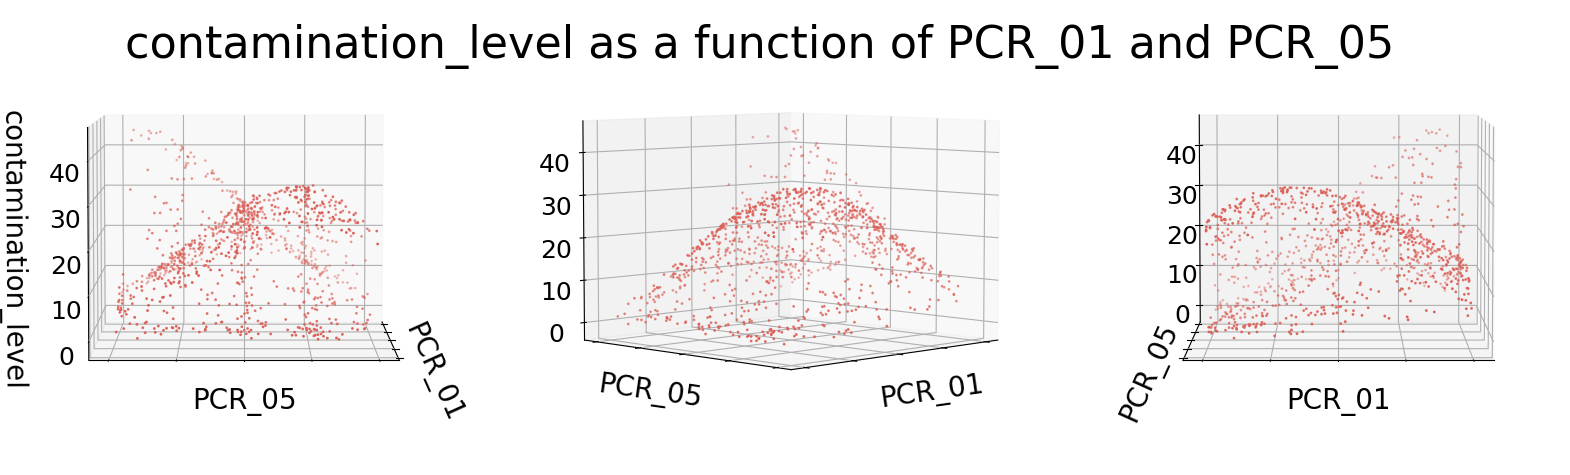

In [26]:
# Q14 - creating a new dataset with only PCR_01 and PCR_05

X_train_pcr = X_train.loc[:, ["PCR_01", "PCR_05"]]

plot3d(train, "PCR_01", "PCR_05", "contamination_level", "contamination_level as a function of PCR_01 and PCR_05")

In [27]:
# Q15 - linear ridge baseline (using PCR_01 and PCR_05)

from sklearn.linear_model import Ridge

alphas = np.logspace(-3, 10, 14, base=2)

cv_test_scores = []
cv_train_scores = []

for alpha in alphas:
    ridge_regressor = Ridge(alpha=alpha, fit_intercept=True)
    cv_scores = cross_validate(ridge_regressor, X_train_pcr, y_train, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_jobs=-1)
    cv_train_scores.append(np.mean(-cv_scores["train_score"]))
    cv_test_scores.append(np.mean(-cv_scores["test_score"]))

best_alpha = alphas[np.argmin(cv_test_scores)]
baseline_validation_mse = cv_test_scores[np.argmin(cv_test_scores)]
print("Best alpha: ", best_alpha)
print("Train MSE: {:.2f}".format(cv_train_scores[np.argmin(cv_test_scores)]))
print("Validation MSE: {:.2f}".format(cv_test_scores[np.argmin(cv_test_scores)]))

Best alpha:  8.0
Train MSE: 94.07
Validation MSE: 94.43


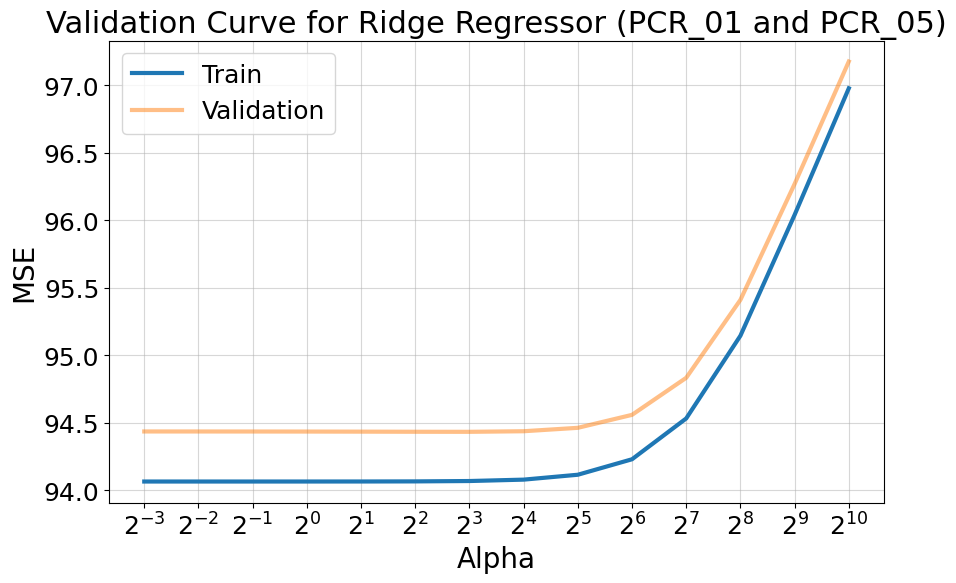

In [28]:
# plotting the results

plt.figure(figsize=(10, 6))
plt.title("Validation Curve for Ridge Regressor (PCR_01 and PCR_05)", fontsize=22)
plt.plot(alphas, cv_train_scores, label="Train", linewidth=3)
plt.plot(alphas, cv_test_scores, label="Validation", linewidth=3, alpha=0.5)
plt.xlabel("Alpha", fontsize=20)
plt.ylabel("MSE", fontsize=20)
plt.grid(alpha=0.5)
plt.semilogx(base=2)
plt.xticks(alphas)
plt.legend()
plt.show()

/tmp/ipykernel_6261/1500650511.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


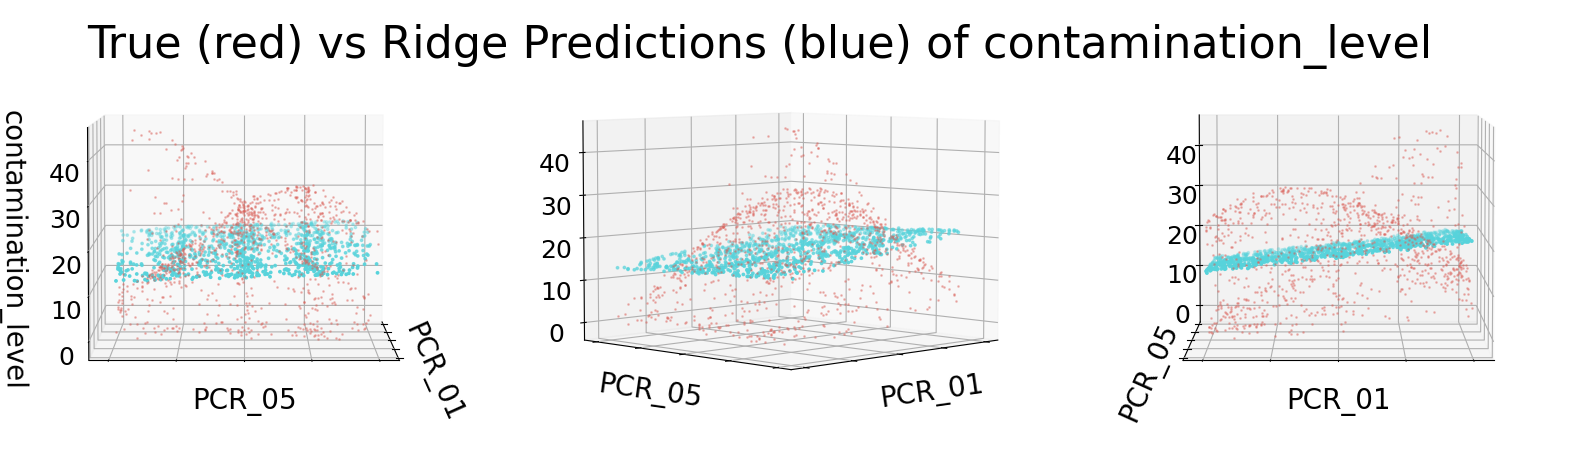

In [29]:
# Q16 - training with the best alpha

optimal_ridge_regressor_pcr = Ridge(alpha=best_alpha, fit_intercept=True)
optimal_ridge_regressor_pcr.fit(X_train_pcr, y_train)
predictions = optimal_ridge_regressor_pcr.predict(X_train_pcr)

plot3d(train, "PCR_01", "PCR_05", "contamination_level", "True (red) vs Ridge Predictions (blue) of contamination_level", predictions=predictions)

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),
                     ('normalization', MinMaxScaler()),
                     ('Ridge', Ridge(fit_intercept=True))])

parameters = {'Ridge__alpha': np.logspace(-3, 10, 14, base=2)}
grid_search = GridSearchCV(poly_reg, parameters, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_pcr, y_train)

best_alpha = grid_search.best_params_["Ridge__alpha"]
print("Best alpha: ", best_alpha)
print("Train MSE: {:.2f}".format(-grid_search.cv_results_["mean_train_score"][grid_search.best_index_]))
print("Validation MSE: {:.2f}".format(-grid_search.cv_results_["mean_test_score"][grid_search.best_index_]))

Best alpha:  1.0
Train MSE: 76.91
Validation MSE: 78.13


In [ ]:
# adding the sugar_levels feature results in a much better validation MSE:

# X_train_pcr_sugar = X_train.loc[:, ["PCR_01", "PCR_05", "sugar_levels"]]

# poly_reg_sugar = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),
#                      ('normalization', MinMaxScaler()),
#                      ('Ridge', Ridge(fit_intercept=True))])

# parameters_sugar = {'Ridge__alpha': np.logspace(-3, 10, 14, base=2)}
# grid_search_sugar = GridSearchCV(poly_reg_sugar, parameters_sugar, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_jobs=-1)
# grid_search_sugar.fit(X_train_pcr_sugar, y_train)

# best_alpha_sugar = grid_search_sugar.best_params_["Ridge__alpha"]
# print("Best alpha: ", best_alpha)
# print("Train MSE: {:.2f}".format(-grid_search_sugar.cv_results_["mean_train_score"][grid_search_sugar.best_index_]))
# print("Validation MSE: {:.2f}".format(-grid_search_sugar.cv_results_["mean_test_score"][grid_search_sugar.best_index_]))

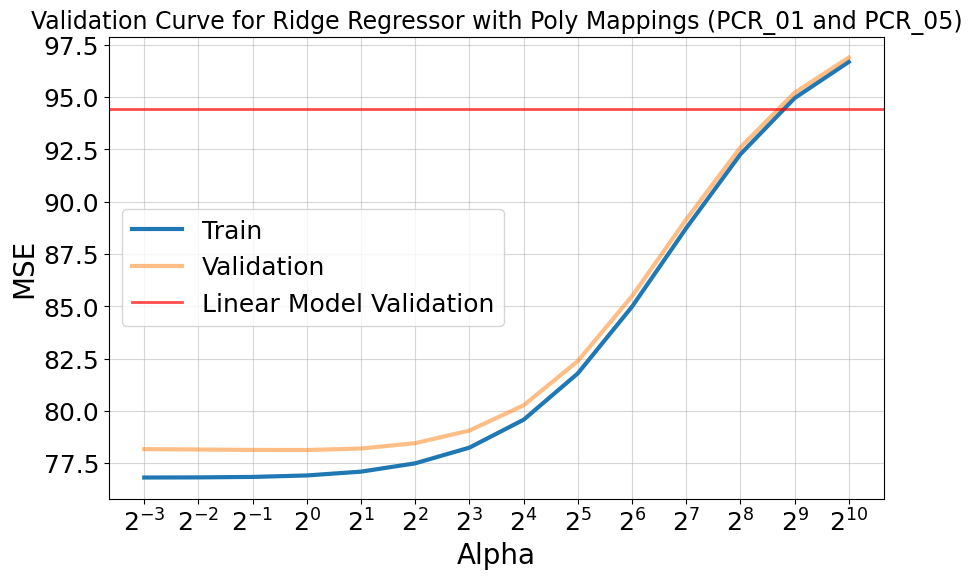

In [31]:
# plotting the results

plt.figure(figsize=(10, 6))
plt.title("Validation Curve for Ridge Regressor with Poly Mappings (PCR_01 and PCR_05)", fontsize=17)
plt.plot(parameters["Ridge__alpha"], -grid_search.cv_results_["mean_train_score"], label="Train", linewidth=3)
plt.plot(parameters["Ridge__alpha"], -grid_search.cv_results_["mean_test_score"], label="Validation", linewidth=3, alpha=0.5)
plt.xlabel("Alpha", fontsize=20)
plt.ylabel("MSE", fontsize=20)
plt.grid(alpha=0.5)
plt.semilogx(base=2)
plt.xticks(parameters["Ridge__alpha"])
# plotting the baseline linear model
plt.axhline(baseline_validation_mse, color="red", label="Linear Model Validation", linewidth=2, alpha=0.7)
plt.legend()
plt.show()

/tmp/ipykernel_6261/1500650511.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


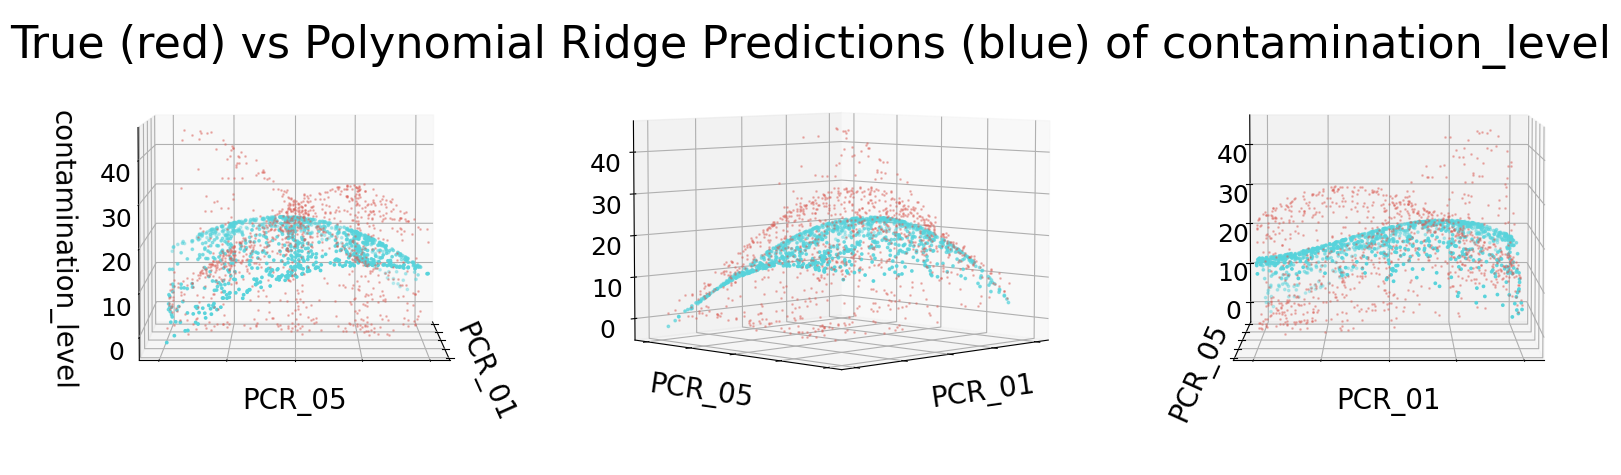

In [32]:
# Q19 - training with the best alpha

best_poly_reg = grid_search.best_estimator_
best_poly_reg.fit(X_train_pcr, y_train)
predictions = best_poly_reg.predict(X_train_pcr)

plot3d(train, "PCR_01", "PCR_05", "contamination_level", "True (red) vs Polynomial Ridge Predictions (blue) of contamination_level", predictions=predictions)

Section 5

In [33]:
# We will now use GBM on PCR1, PCR2, PCR3, PCR4, PCR5,
#                        PCR9, PCR10, sugar_levels, and sport_activity

X_train_gbm = train.loc[:, ["PCR_01", "PCR_02", "PCR_03", "PCR_04", "PCR_05", "PCR_09", "PCR_10", "sugar_levels", "sport_activity"]].copy()
y_train_gbm = train.loc[:, "contamination_level"].copy()

In [34]:
# Q23 - hyperparameter tuning (loss, learning_rate, subsample and min_samples_leaf)

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

losses = ["squared_error", "absolute_error", "huber"]
learning_rates = np.logspace(-3, 0, 4, base=10)
subsamples = np.linspace(0.1, 1, 10)
min_samples_leafs = np.linspace(1, 10, 10, dtype=int)

parameters = {  'loss': losses,
                'learning_rate': learning_rates,
                'subsample': subsamples,
                'min_samples_leaf': min_samples_leafs
            }

gbm_regressor = GradientBoostingRegressor(random_state=42) # constant random_state for reproducibility
grid_search = GridSearchCV(gbm_regressor, parameters, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_jobs=-1)
_ = grid_search.fit(X_train_gbm, y_train_gbm)

In [35]:
best_params = grid_search.best_params_
print("Best parameters: ", best_params)
print("Train MSE: {:.2f}".format(-grid_search.cv_results_["mean_train_score"][grid_search.best_index_]))
print("Validation MSE: {:.2f}".format(-grid_search.cv_results_["mean_test_score"][grid_search.best_index_]))

Best parameters:  {'learning_rate': 0.1, 'loss': 'huber', 'min_samples_leaf': 6, 'subsample': 0.6}
Train MSE: 2.39
Validation MSE: 3.87


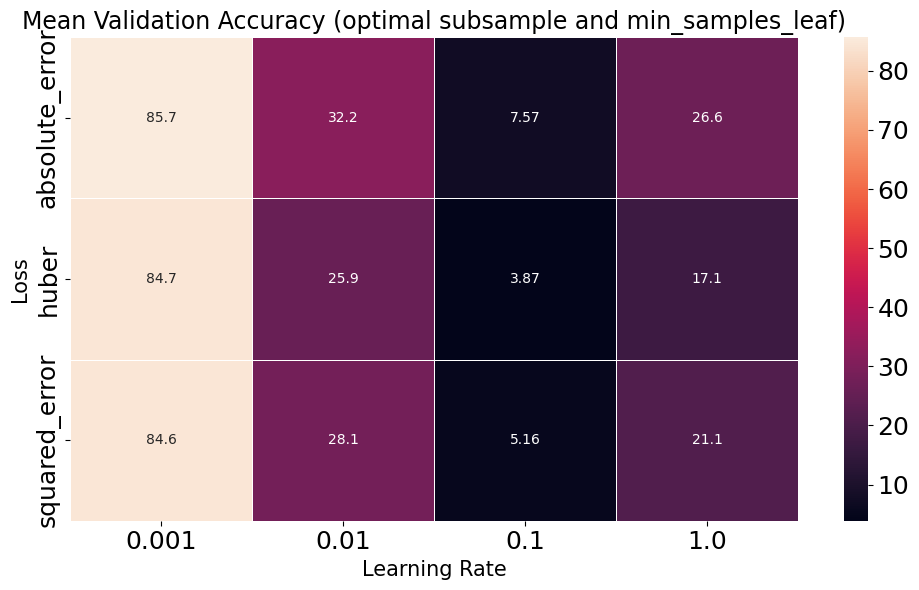

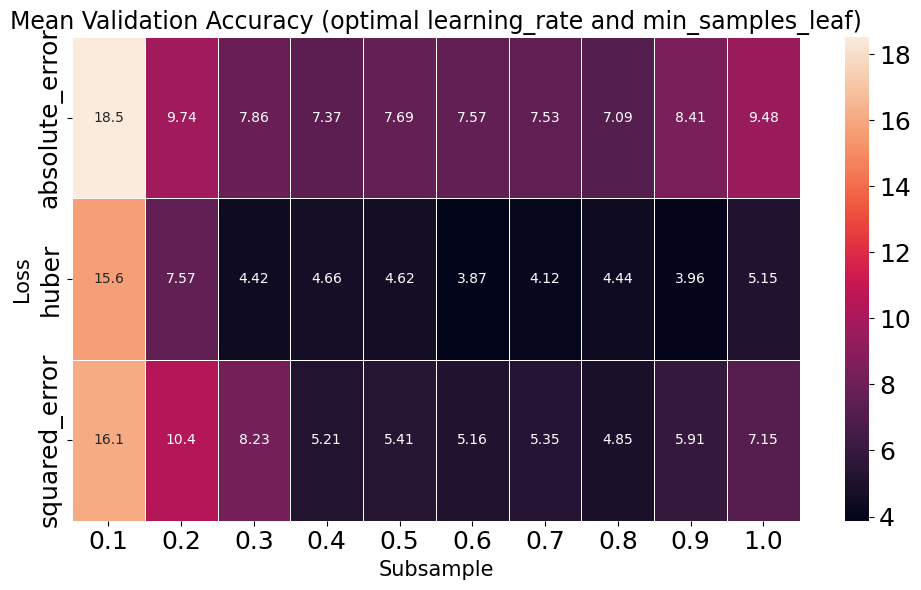

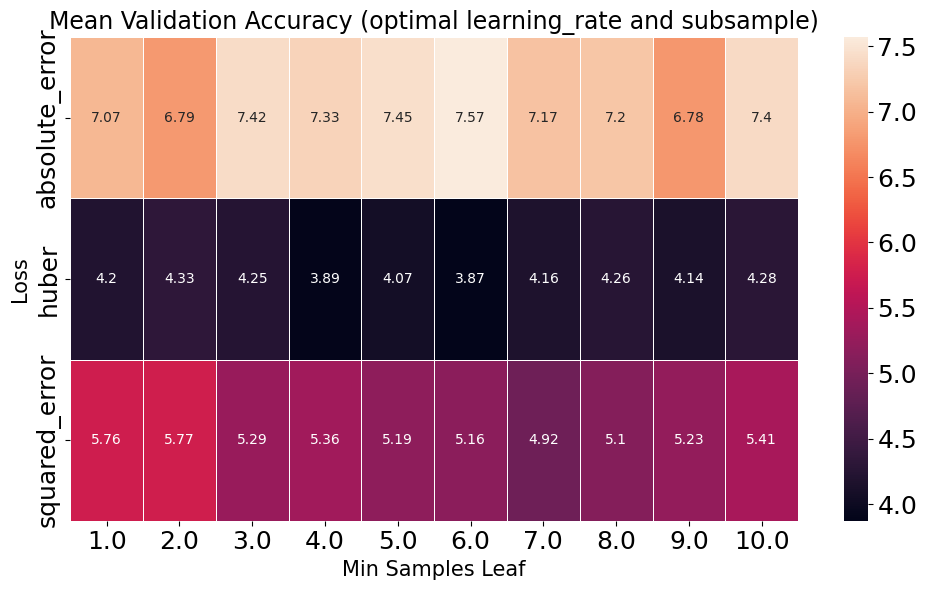

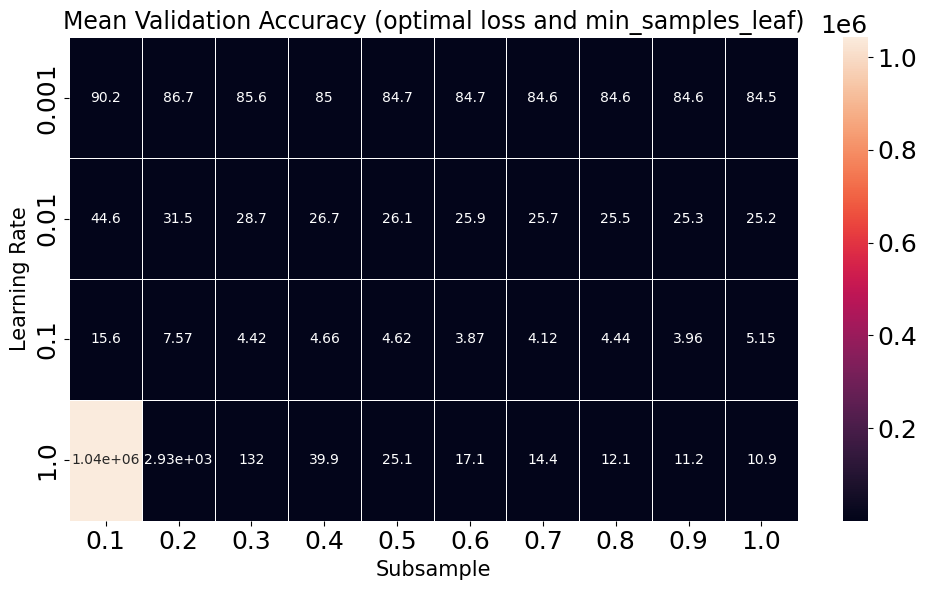

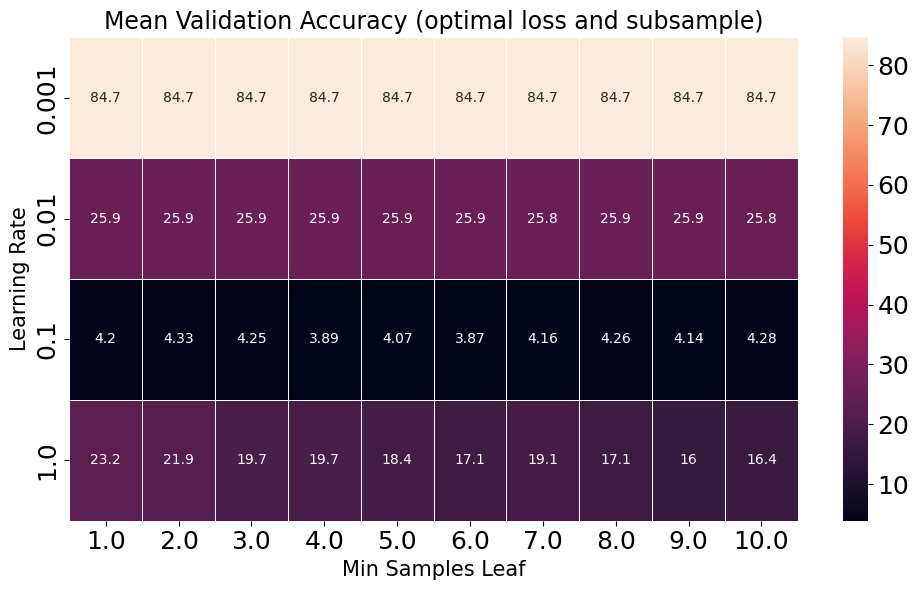

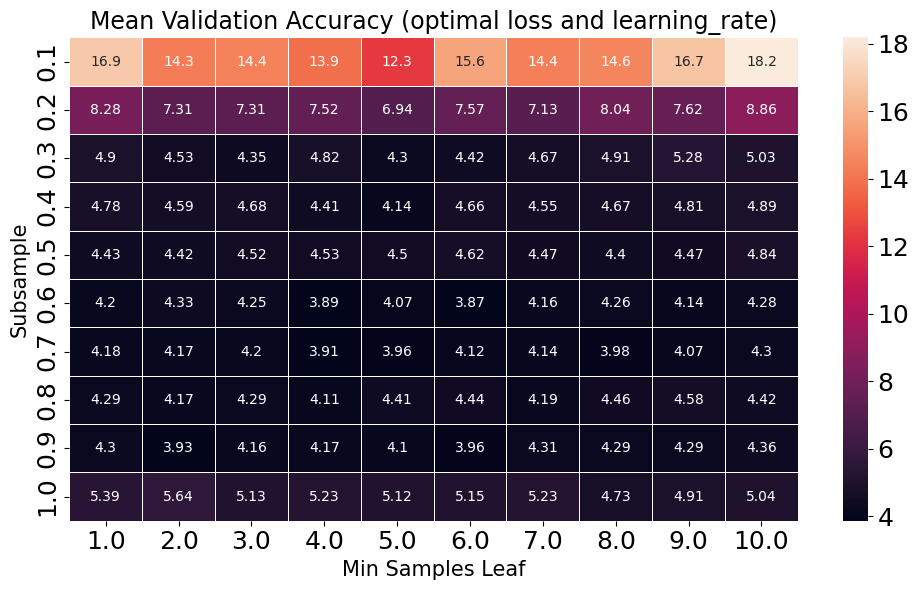

In [36]:
# heatmaps for the hyperparameters
# heatmaps will be in pairs:
#   take multiple values of loss & learning_rates for the optimal subsample & min_samples_leaf (#1)
#   take multiple values of loss & subsample for the optimal learning_rates & samples_leaf (#2)
#   take multiple values of loss & min_samples_leaf for the optimal learning_rates & subsample (#3)
#   take multiple values of learning_rates & subsample for the optimal loss & min_samples_leaf (#4)
#   take multiple values of learning_rates & min_samples_leaf for the optimal loss & subsample (#5)
#   take multiple values of subsample & min_samples_leaf for the optimal loss & learning_rates (#6)

import seaborn as sns

# loss & learning_rates for the optimal subsample & min_samples_leaf (#1)

best_loss = best_params["loss"]
best_learning_rate = best_params["learning_rate"]
best_subsample = best_params["subsample"]
best_min_samples_leaf = best_params["min_samples_leaf"]

losses = ["squared_error", "absolute_error", "huber", "quantile"]
learning_rates = np.logspace(-3, 0, 4, base=10)
subsamples = np.linspace(0.1, 1, 10)
min_samples_leafs = np.linspace(0.1, 0.5, 5)

def get_results(gbm_regressor : GradientBoostingRegressor, param1 : str, param2 : str):
    this_params = { param1: parameters[param1], param2: parameters[param2] }
    grid_search = GridSearchCV(gbm_regressor, this_params, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train_gbm, y_train_gbm)
    results = pd.DataFrame(grid_search.cv_results_)
    results = results.pivot(index="param_"+param1, columns="param_"+param2, values="mean_test_score")
    # if not string, make it be np.float32 to make the heatmap look better
    if not isinstance(results.columns[0], str):
        results.columns = results.columns.astype(np.float32)
    if not isinstance(results.index[0], str):
        results.index = results.index.astype(np.float32)
    return -results

def plot_heatmap(results, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=17)
    sns.heatmap(results, annot=True, fmt=".3g", linewidths=0.5)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.tight_layout()
    plt.show()

gbm_regressor_1 = GradientBoostingRegressor(subsample=best_subsample, min_samples_leaf=best_min_samples_leaf, random_state=42)
results_1 = get_results(gbm_regressor_1, "loss", "learning_rate")
plot_heatmap(results_1, "Mean Validation Accuracy (optimal subsample and min_samples_leaf)", "Learning Rate", "Loss")

gbm_regressor_2 = GradientBoostingRegressor(learning_rate=best_learning_rate, min_samples_leaf=best_min_samples_leaf, random_state=42)
results_2 = get_results(gbm_regressor_2, "loss", "subsample")
plot_heatmap(results_2, "Mean Validation Accuracy (optimal learning_rate and min_samples_leaf)", "Subsample", "Loss")

gbm_regressor_3 = GradientBoostingRegressor(learning_rate=best_learning_rate, subsample=best_subsample, random_state=42)
results_3 = get_results(gbm_regressor_3, "loss", "min_samples_leaf")
plot_heatmap(results_3, "Mean Validation Accuracy (optimal learning_rate and subsample)", "Min Samples Leaf", "Loss")

gbm_regressor_4 = GradientBoostingRegressor(loss=best_loss, min_samples_leaf=best_min_samples_leaf, random_state=42)
results_4 = get_results(gbm_regressor_4, "learning_rate", "subsample")
plot_heatmap(results_4, "Mean Validation Accuracy (optimal loss and min_samples_leaf)", "Subsample", "Learning Rate")

gbm_regressor_5 = GradientBoostingRegressor(loss=best_loss, subsample=best_subsample, random_state=42)
results_5 = get_results(gbm_regressor_5, "learning_rate", "min_samples_leaf")
plot_heatmap(results_5, "Mean Validation Accuracy (optimal loss and subsample)", "Min Samples Leaf", "Learning Rate")

gbm_regressor_6 = GradientBoostingRegressor(loss=best_loss, learning_rate=best_learning_rate, random_state=42)
results_6 = get_results(gbm_regressor_6, "subsample", "min_samples_leaf")
plot_heatmap(results_6, "Mean Validation Accuracy (optimal loss and learning_rate)", "Min Samples Leaf", "Subsample")


In [59]:
# training with the optimal hyperparameters

X_test_gbm = test.loc[:, ["PCR_01", "PCR_02", "PCR_03", "PCR_04", "PCR_05", "PCR_09", "PCR_10", "sugar_levels", "sport_activity"]].copy()
y_test_gbm = test.loc[:, "contamination_level"].copy()

# random state for reproducibility
gbm_regressor = GradientBoostingRegressor(loss=best_loss, learning_rate=best_learning_rate, subsample=best_subsample, min_samples_leaf=best_min_samples_leaf, random_state=42)
gbm_regressor.fit(X_train_gbm, y_train_gbm)
predictions = gbm_regressor.predict(X_test_gbm)

print("Test MSE: {:.2f}".format(mean_squared_error(y_test_gbm, predictions)))

Test MSE: 3.79
